In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import shapiro
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Caminho base absoluto
base_path = Path("C:/Users/rafaa/Documents/GitHub/Projeto_ASTP")

# Caminhos completos
flights_2021_path = base_path / "dataset" / "Voos_cleaned" / "Cleaned_Flights_2021.csv"
flights_2022_path = base_path / "dataset" / "Voos_cleaned" / "Cleaned_Flights_2022.csv"
weather_path = base_path / "dataset" / "Wheater_cleaned" / "WeatherEvents_2021_2022.csv"

# Carregamento dos dados
flights_2021 = pd.read_csv(flights_2021_path, parse_dates=["FlightDate"])
flights_2022 = pd.read_csv(flights_2022_path, parse_dates=["FlightDate"])
weather = pd.read_csv(weather_path, parse_dates=["StartTime(UTC)", "EndTime(UTC)"])

# Combinar os dados de voos
flights = pd.concat([flights_2021, flights_2022])
flights.sort_values("FlightDate", inplace=True)

In [6]:
# === 2. Séries Temporais === #
voos_dia = flights.groupby("FlightDate").size()
atraso_medio_dia = flights.groupby("FlightDate")["DepDelayMinutes"].mean()
percent_cancelado = flights.groupby("FlightDate")["Cancelled"].mean()

# Eventos meteorológicos por dia
weather["EventDate"] = weather["StartTime(UTC)"].dt.date
eventos_meteo_dia = weather.groupby("EventDate").size()
eventos_meteo_dia.index = pd.to_datetime(eventos_meteo_dia.index)

# Unir tudo num único DataFrame
eda_df = pd.concat([
    voos_dia.rename("NumVoos"),
    atraso_medio_dia.rename("AtrasoMedio"),
    percent_cancelado.rename("PercentCancelado"),
    eventos_meteo_dia.rename("EventosMeteo")
], axis=1)



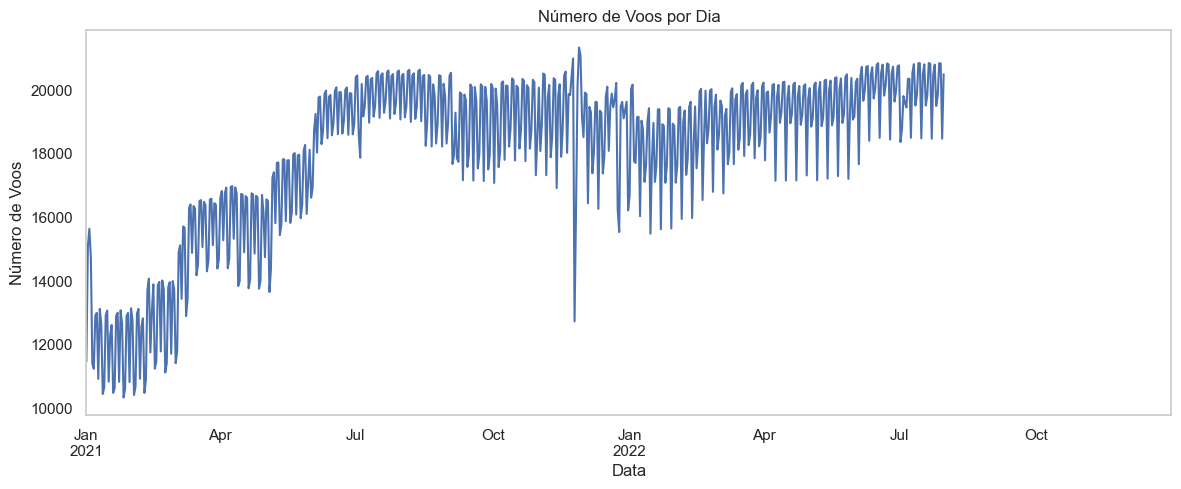

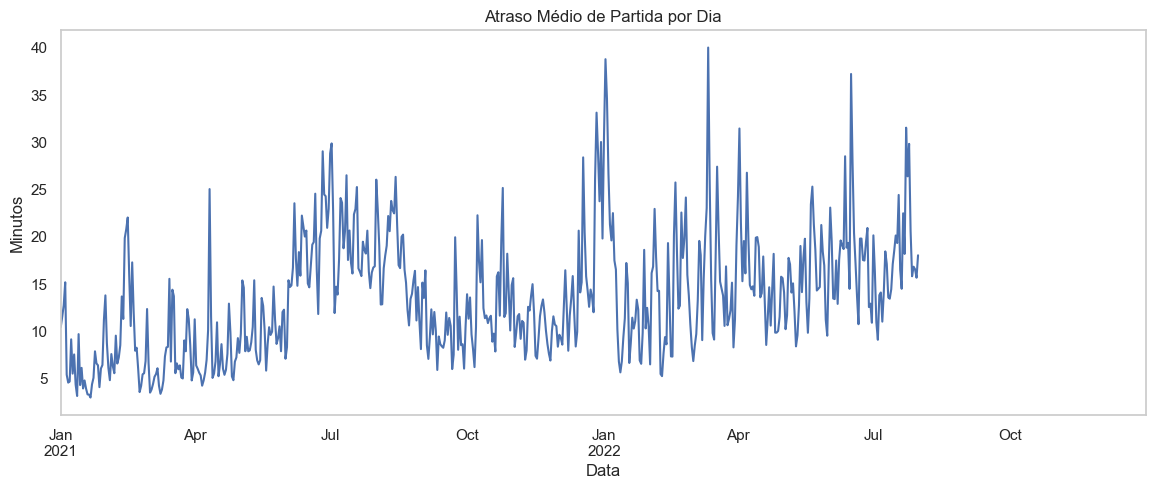

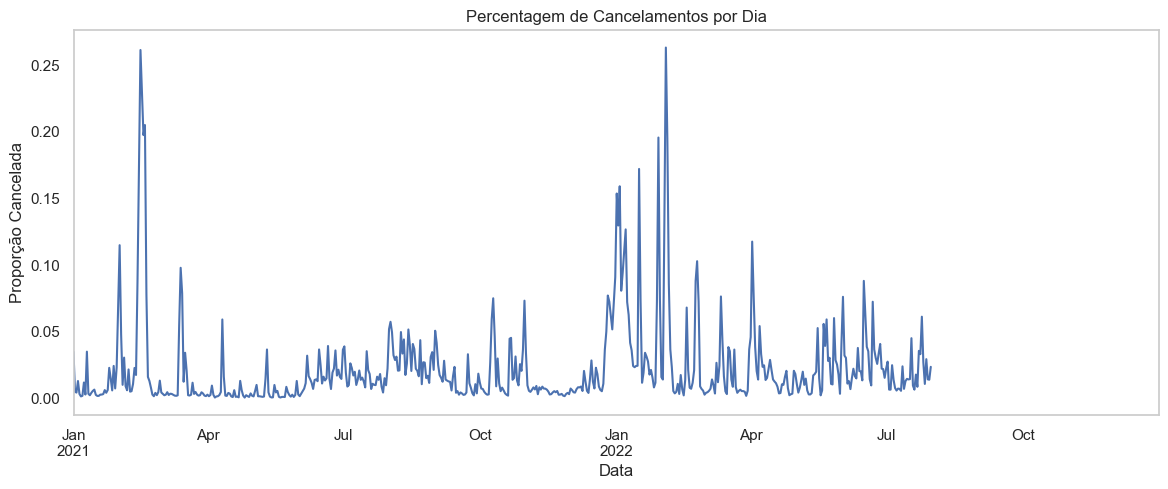

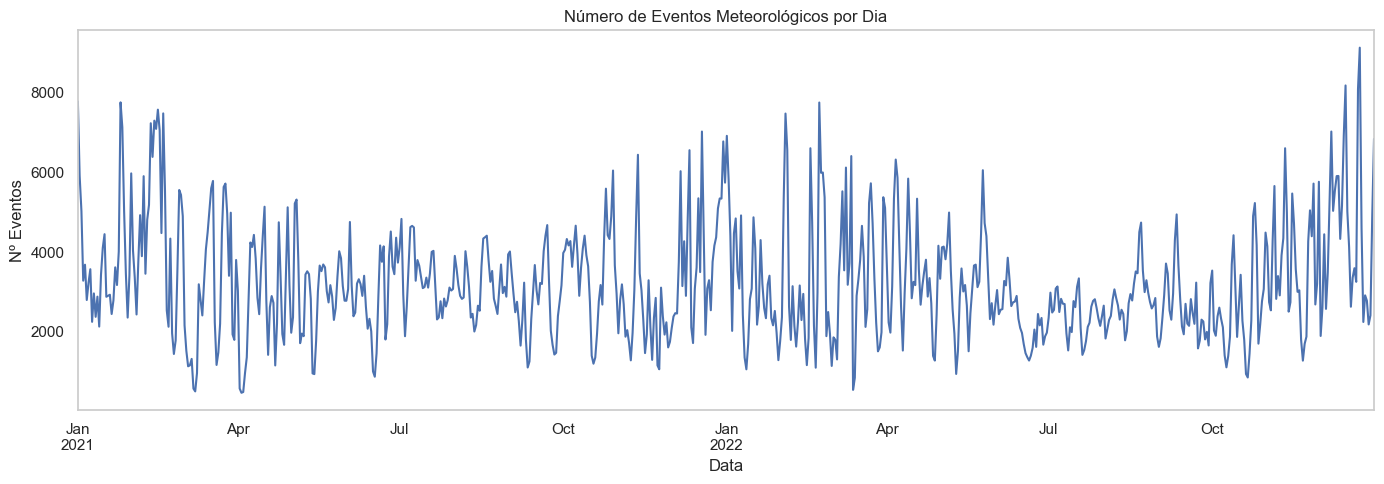

In [7]:
# === 3. Visualizações === #
plt.figure(figsize=(14, 5))
eda_df["NumVoos"].plot(title="Número de Voos por Dia")
plt.xlabel("Data")
plt.ylabel("Número de Voos")
plt.grid()

plt.figure(figsize=(14, 5))
eda_df["AtrasoMedio"].plot(title="Atraso Médio de Partida por Dia")
plt.xlabel("Data")
plt.ylabel("Minutos")
plt.grid()

plt.figure(figsize=(14, 5))
eda_df["PercentCancelado"].plot(title="Percentagem de Cancelamentos por Dia")
plt.xlabel("Data")
plt.ylabel("Proporção Cancelada")
plt.grid()

plt.figure(figsize=(14, 5))
eda_df["EventosMeteo"].fillna(0).plot(title="Número de Eventos Meteorológicos por Dia")
plt.xlabel("Data")
plt.ylabel("Nº Eventos")
plt.grid()

plt.tight_layout()
plt.show()





--- Teste de Estacionariedade (ADF) para Atraso Médio ---
ADF Statistic: -2.8727
p-value: 0.0486
=> Série estacionária (rejeita H0)

--- Teste de Normalidade (Shapiro-Wilk) para Atraso Médio ---
Estatística: 0.9650 | p-valor: 0.0000
=> Distribuição NÃO é normal (rejeita H0)


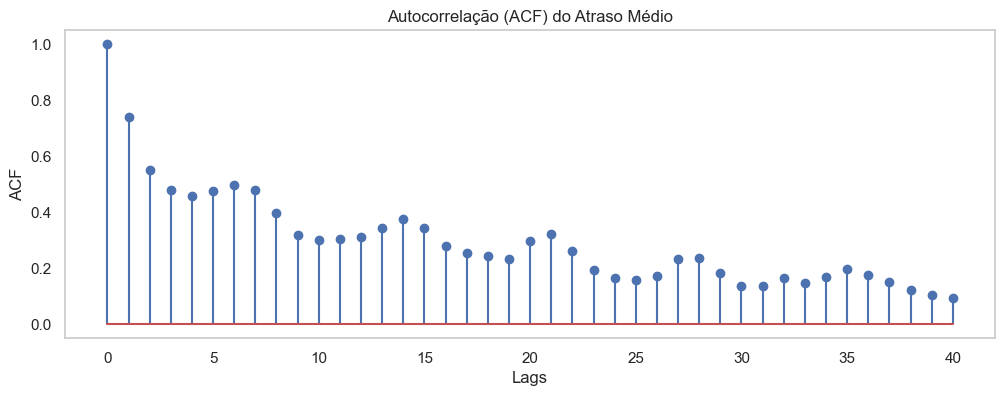

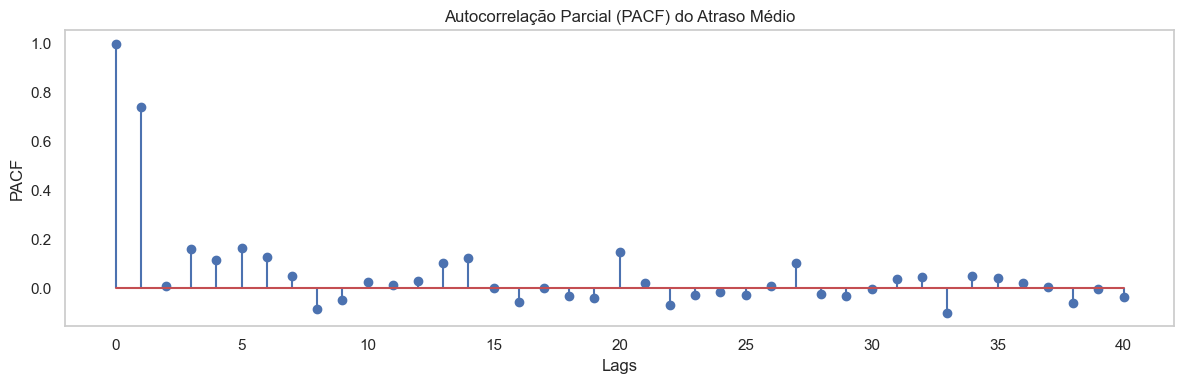

In [9]:
# === 4. Testes Estatísticos === #
print("\n--- Teste de Estacionariedade (ADF) para Atraso Médio ---")
atraso_series = eda_df["AtrasoMedio"].dropna()
adf_result = adfuller(atraso_series)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("=> Série estacionária (rejeita H0)")
else:
    print("=> Série NÃO estacionária (não rejeita H0)")

print("\n--- Teste de Normalidade (Shapiro-Wilk) para Atraso Médio ---")
sample = atraso_series.sample(n=500, random_state=42)
shapiro_stat, shapiro_p = shapiro(sample)
print(f"Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")
if shapiro_p < 0.05:
    print("=> Distribuição NÃO é normal (rejeita H0)")
else:
    print("=> Distribuição é aproximadamente normal")

# === 5. ACF e PACF === #
lags = 40
acf_vals = acf(atraso_series, nlags=lags)
pacf_vals = pacf(atraso_series, nlags=lags)

plt.figure(figsize=(12, 4))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelação (ACF) do Atraso Médio")
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.grid()

plt.figure(figsize=(12, 4))
plt.stem(range(len(pacf_vals)), pacf_vals)
plt.title("Autocorrelação Parcial (PACF) do Atraso Médio")
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.grid()

plt.tight_layout()
plt.show()
